<a href="https://colab.research.google.com/github/darsh90/SRGAN/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import tensorflow as tf

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchvision import transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import random
import argparse
import os
import sys
import numpy as np

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp
import numpy
import math
import numpy
import scipy.signal
import scipy.ndimage

In [ ]:
# class to extract features for the input image in a different image space like VGG19, AlexNet, DenseNet, etc.
class FeatureExtractor(nn.Module):
    
    def __init__(self, cnn, feature_layer=11):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(cnn.features.children())[:(feature_layer+1)])

    def forward(self, x):
        return self.features(x)

# class to implement ResNet blocks
class residualBlock(nn.Module):
    
    def __init__(self, in_channels=64, k=3, n=64, s=1):
        super(residualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, n, k, stride=s, padding=1)
        self.bn1 = nn.BatchNorm2d(n)
        self.prelu1 = nn.PReLU(n)
        self.conv2 = nn.Conv2d(n, n, k, stride=s, padding=1)
        self.bn2 = nn.BatchNorm2d(n)

    def forward(self, x):
        y = self.prelu1(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x

# class to upsample the input to required dimensions    
class upsampleBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, factor):
        super(upsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)
        self.shuffler = nn.PixelShuffle(factor)
        self.prelu = nn.PReLU(int(out_channels/(factor**2)))

    def forward(self, x):
        return self.prelu(self.shuffler(self.conv(x)))

# generator class definition    
class Generator(nn.Module):
    
    def __init__(self, n_residual_blocks, upsample_factor):
        super(Generator, self).__init__()
        self.n_residual_blocks = n_residual_blocks
        self.upsample_factor = upsample_factor

        self.conv1 = nn.Conv2d(3, 64, 9, stride=1, padding=4)
        self.prelu1 = nn.PReLU(64)

        for i in range(self.n_residual_blocks):
            self.add_module('residual_block' + str(i+1), residualBlock())

        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        for i in range(int(self.upsample_factor/2)):
            self.add_module('upsample' + str(i+1), upsampleBlock(64, 256, self.upsample_factor))

        self.conv3 = nn.Conv2d(64, 3, 9, stride=1, padding=4)

    def forward(self, x):
        x = self.prelu1(self.conv1(x))

        y = x.clone()
        for i in range(self.n_residual_blocks):
            y = self.__getattr__('residual_block' + str(i+1))(y)

        x = self.bn2(self.conv2(y)) + x

        for i in range(int(self.upsample_factor/2)):
            x = self.__getattr__('upsample' + str(i+1))(x)

        return self.conv3(x)

# discriminator class definition    
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
      
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(64, 64, 3, stride=2, padding=1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(64, 128, 3, stride=1, padding=1))
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(128, 128, 3, stride=2, padding=1))
        self.conv5 = nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, stride=1, padding=1))
        self.conv6 = nn.utils.spectral_norm(nn.Conv2d(256, 256, 3, stride=2, padding=1))
        self.conv7 = nn.utils.spectral_norm(nn.Conv2d(256, 512, 3, stride=1, padding=1))
        self.conv8 = nn.utils.spectral_norm(nn.Conv2d(512, 512, 3, stride=2, padding=1))

        self.conv9 = nn.Conv2d(512, 1, 1, stride=1, padding=1)
        
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))

        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.leakyrelu(self.conv4(x))
        x = self.leakyrelu(self.conv5(x))
        x = self.leakyrelu(self.conv6(x))
        x = self.leakyrelu(self.conv7(x))
        x = self.leakyrelu(self.conv8(x))

        x = self.conv9(x)
        return F.avg_pool2d(x, x.size()[2:])#.view(x.size()[0], -1), F.avg_pool2d(x, x.size()[2:])

# class to visualize results    
class Visualizer:
    
    def __init__(self, show_step=100, image_size=30):
        self.transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2)),
                                            transforms.ToPILImage(),
                                            transforms.Scale(image_size)])

        self.show_step = show_step
        self.step = 0

        self.figure, (self.lr_plot, self.hr_plot, self.fake_plot) = plt.subplots(1,3)
        self.figure.show()

        self.lr_image_ph = None
        self.hr_image_ph = None
        self.fake_hr_image_ph = None

    def show(self, inputsG, inputsD_real, inputsD_fake):

        self.step += 1
        
        if self.step == self.show_step:
            i = random.randint(0, inputsG.size(0) -1)

            lr_image = self.transform(inputsG[i])
            hr_image = self.transform(inputsD_real[i])
            fake_hr_image = self.transform(inputsD_fake[i])

            if self.lr_image_ph is None:
                self.lr_image_ph = self.lr_plot.imshow(lr_image)
                self.hr_image_ph = self.hr_plot.imshow(hr_image)
                self.fake_hr_image_ph = self.fake_plot.imshow(fake_hr_image)
            else:
                self.lr_image_ph.set_data(lr_image)
                self.hr_image_ph.set_data(hr_image)
                self.fake_hr_image_ph.set_data(fake_hr_image)

            self.figure.canvas.draw()
            plt.pause(0.001)
            
            self.step = 0
            self.figure, (self.lr_plot, self.hr_plot, self.fake_plot) = plt.subplots(1,3)
            self.lr_image_ph = None
            self.hr_image_ph = None
            self.fake_hr_image_ph = None

            
# Image quality metrics

# 1. SSIM - Structural Similarity Metric
def _ssim(img1, img2, window, window_size, channel, size_average = True):
  
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average).item()

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window
  
# 2. VIFP - Visual Information Fidelity Measure 
def vifp_measure(ref, dist):
  
    ref = ref.cpu().detach().numpy()
    dist = dist.cpu().detach().numpy()
    sigma_nsq=2
    eps = 1e-10

    num = 0.0
    den = 0.0
    for scale in range(1, 5):
       
        N = 2**(4-scale+1) + 1
        sd = N/5.0

        if (scale > 1):
            ref = scipy.ndimage.gaussian_filter(ref, sd)
            dist = scipy.ndimage.gaussian_filter(dist, sd)
            ref = ref[::2, ::2]
            dist = dist[::2, ::2]
                
        mu1 = scipy.ndimage.gaussian_filter(ref, sd)
        mu2 = scipy.ndimage.gaussian_filter(dist, sd)
        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2
        sigma1_sq = scipy.ndimage.gaussian_filter(ref * ref, sd) - mu1_sq
        sigma2_sq = scipy.ndimage.gaussian_filter(dist * dist, sd) - mu2_sq
        sigma12 = scipy.ndimage.gaussian_filter(ref * dist, sd) - mu1_mu2
        
        sigma1_sq[sigma1_sq<0] = 0
        sigma2_sq[sigma2_sq<0] = 0
        
        g = sigma12 / (sigma1_sq + eps)
        sv_sq = sigma2_sq - g * sigma12
        
        g[sigma1_sq<eps] = 0
        sv_sq[sigma1_sq<eps] = sigma2_sq[sigma1_sq<eps]
        sigma1_sq[sigma1_sq<eps] = 0
        
        g[sigma2_sq<eps] = 0
        sv_sq[sigma2_sq<eps] = 0
        
        sv_sq[g<0] = sigma2_sq[g<0]
        g[g<0] = 0
        sv_sq[sv_sq<=eps] = eps
        
        num += numpy.sum(numpy.log10(1 + g * g * sigma1_sq / (sv_sq + sigma_nsq)))
        den += numpy.sum(numpy.log10(1 + sigma1_sq / sigma_nsq))
        
    vifp = num/den

    return vifp  

def psnr(im1, im2):
    img1 = cv2.imread('im1')
    img2 = cv2.imread('im2')
    psr = cv2.PSNR(img1, img2)
    return psr

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Model training




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")




[1/100][1/10] Discriminator_Loss: 1.3864 Generator_Loss (Content/Advers/Total): 0.4552/0.6931/0.4559 (SSIM) = (0.0067)


[1/100][6/10] Discriminator_Loss: 1.3662 Generator_Loss (Content/Advers/Total): 0.1434/0.5671/0.1439 (SSIM) = (0.1173)


[1/100][10/10] Mean_Discriminator_Loss: 1.3793 Mean_Generator_Loss (Content/Advers/Total): 0.2049/0.5897/0.2055 (Mean_SSIM) = (0.1030)


[6/100][10/10] Mean_Discriminator_Loss: 1.1274 Mean_Generator_Loss (Content/Advers/Total): 0.0638/0.0296/0.0639 (Mean_SSIM) = (0.4194)


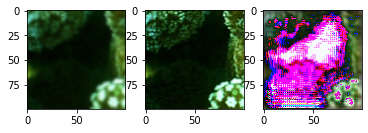



[11/100][1/10] Discriminator_Loss: 0.9880 Generator_Loss (Content/Advers/Total): 0.0469/0.1730/0.0471 (SSIM) = (0.5366)


[11/100][6/10] Discriminator_Loss: 1.0119 Generator_Loss (Content/Advers/Total): 0.0427/0.1566/0.0428 (SSIM) = (0.5295)


[11/100][10/10] Mean_Discriminator_Loss: 0.9833 Mean_Generator_Loss (Content/Advers/Total): 0.0458/0.1585/0.0459 (Mean_SSIM) = (0.5243)


[16/100][10/10] Mean_Discriminator_Loss: 0.9588 Mean_Generator_Loss (Content/Advers/Total): 0.0394/0.0805/0.0394 (Mean_SSIM) = (0.5771)


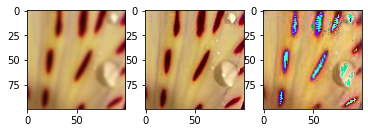



[21/100][1/10] Discriminator_Loss: 0.9361 Generator_Loss (Content/Advers/Total): 0.0394/0.0052/0.0394 (SSIM) = (0.6032)


[21/100][6/10] Discriminator_Loss: 0.8168 Generator_Loss (Content/Advers/Total): 0.0316/0.0101/0.0316 (SSIM) = (0.6330)


[21/100][10/10] Mean_Discriminator_Loss: 0.8037 Mean_Generator_Loss (Content/Advers/Total): 0.0334/0.0090/0.0335 (Mean_SSIM) = (0.6291)


[26/100][10/10] Mean_Discriminator_Loss: 0.8257 Mean_Generator_Loss (Content/Advers/Total): 0.0309/0.0350/0.0310 (Mean_SSIM) = (0.6490)


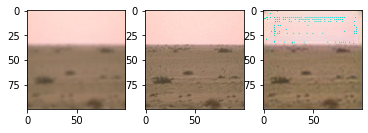



[31/100][1/10] Discriminator_Loss: 0.7821 Generator_Loss (Content/Advers/Total): 0.0265/0.0121/0.0265 (SSIM) = (0.6809)


[31/100][6/10] Discriminator_Loss: 0.6961 Generator_Loss (Content/Advers/Total): 0.0271/0.0158/0.0271 (SSIM) = (0.6857)


[31/100][10/10] Mean_Discriminator_Loss: 0.7632 Mean_Generator_Loss (Content/Advers/Total): 0.0280/0.0122/0.0280 (Mean_SSIM) = (0.6767)


[36/100][10/10] Mean_Discriminator_Loss: 0.7556 Mean_Generator_Loss (Content/Advers/Total): 0.0269/0.0218/0.0269 (Mean_SSIM) = (0.6849)


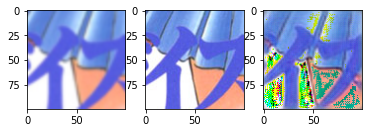



[41/100][1/10] Discriminator_Loss: 0.7288 Generator_Loss (Content/Advers/Total): 0.0243/0.0829/0.0244 (SSIM) = (0.6935)


[41/100][6/10] Discriminator_Loss: 0.6468 Generator_Loss (Content/Advers/Total): 0.0274/0.0691/0.0275 (SSIM) = (0.7094)


[41/100][10/10] Mean_Discriminator_Loss: 0.7207 Mean_Generator_Loss (Content/Advers/Total): 0.0253/0.0781/0.0253 (Mean_SSIM) = (0.7030)


[46/100][10/10] Mean_Discriminator_Loss: 0.7565 Mean_Generator_Loss (Content/Advers/Total): 0.0243/0.3450/0.0246 (Mean_SSIM) = (0.7131)


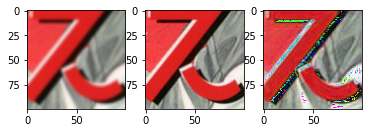



[51/100][1/10] Discriminator_Loss: 0.7491 Generator_Loss (Content/Advers/Total): 0.0247/0.8812/0.0256 (SSIM) = (0.7065)


[51/100][6/10] Discriminator_Loss: 0.6933 Generator_Loss (Content/Advers/Total): 0.0234/0.6204/0.0241 (SSIM) = (0.7243)


[51/100][10/10] Mean_Discriminator_Loss: 0.7218 Mean_Generator_Loss (Content/Advers/Total): 0.0235/0.7834/0.0243 (Mean_SSIM) = (0.7242)


[56/100][10/10] Mean_Discriminator_Loss: 0.7307 Mean_Generator_Loss (Content/Advers/Total): 0.0228/1.3635/0.0242 (Mean_SSIM) = (0.7308)


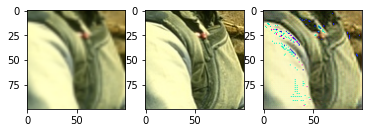



[61/100][1/10] Discriminator_Loss: 0.6931 Generator_Loss (Content/Advers/Total): 0.0218/1.8186/0.0237 (SSIM) = (0.7356)


[61/100][6/10] Discriminator_Loss: 0.6236 Generator_Loss (Content/Advers/Total): 0.0241/1.4483/0.0255 (SSIM) = (0.7330)


[61/100][10/10] Mean_Discriminator_Loss: 0.6878 Mean_Generator_Loss (Content/Advers/Total): 0.0221/1.5055/0.0236 (Mean_SSIM) = (0.7380)


[66/100][10/10] Mean_Discriminator_Loss: 0.7187 Mean_Generator_Loss (Content/Advers/Total): 0.0220/1.7212/0.0238 (Mean_SSIM) = (0.7398)


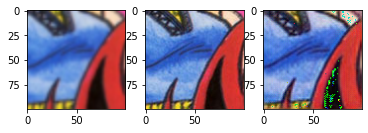



[71/100][1/10] Discriminator_Loss: 0.6739 Generator_Loss (Content/Advers/Total): 0.0237/1.6555/0.0253 (SSIM) = (0.7364)


[71/100][6/10] Discriminator_Loss: 0.6798 Generator_Loss (Content/Advers/Total): 0.0249/1.4414/0.0264 (SSIM) = (0.7389)


[71/100][10/10] Mean_Discriminator_Loss: 0.6963 Mean_Generator_Loss (Content/Advers/Total): 0.0213/1.7053/0.0230 (Mean_SSIM) = (0.7454)


[76/100][10/10] Mean_Discriminator_Loss: 0.7008 Mean_Generator_Loss (Content/Advers/Total): 0.0207/1.6491/0.0223 (Mean_SSIM) = (0.7511)


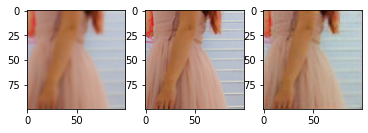



[81/100][1/10] Discriminator_Loss: 0.7727 Generator_Loss (Content/Advers/Total): 0.0182/2.0138/0.0202 (SSIM) = (0.7587)


[81/100][6/10] Discriminator_Loss: 0.7805 Generator_Loss (Content/Advers/Total): 0.0233/2.7794/0.0261 (SSIM) = (0.7550)


[81/100][10/10] Mean_Discriminator_Loss: 0.7222 Mean_Generator_Loss (Content/Advers/Total): 0.0201/2.3142/0.0224 (Mean_SSIM) = (0.7596)


[86/100][10/10] Mean_Discriminator_Loss: 0.6889 Mean_Generator_Loss (Content/Advers/Total): 0.0198/1.9451/0.0217 (Mean_SSIM) = (0.7618)


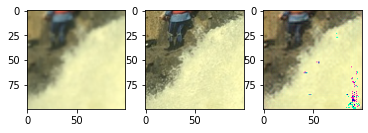



[91/100][1/10] Discriminator_Loss: 0.6990 Generator_Loss (Content/Advers/Total): 0.0176/1.5172/0.0192 (SSIM) = (0.7637)


[91/100][6/10] Discriminator_Loss: 0.7480 Generator_Loss (Content/Advers/Total): 0.0189/2.1012/0.0210 (SSIM) = (0.7599)


[91/100][10/10] Mean_Discriminator_Loss: 0.7010 Mean_Generator_Loss (Content/Advers/Total): 0.0194/1.8775/0.0213 (Mean_SSIM) = (0.7662)


[96/100][10/10] Mean_Discriminator_Loss: 0.7166 Mean_Generator_Loss (Content/Advers/Total): 0.0189/1.8675/0.0208 (Mean_SSIM) = (0.7707)


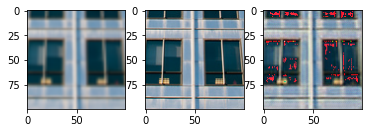

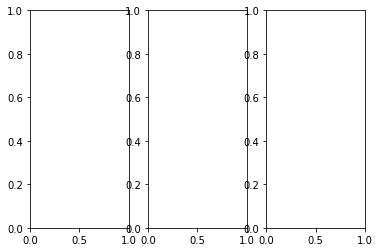

In [ ]:
"""
Training the model

"""

dataset = 'train'
dataroot = '/content/data/train'
MGT=[]
MDT=[]
MSSIM=[]
MVIFP=[]
MGT0=[]
MDT0=[]
MSSIM0=[]
MVIFP0=[]
workers = 4
batchSize = 60
imageSize = 50
upSampling = 2
nEpochs = 100
cuda = True
generatorWeights = ''
discriminatorWeights = ''
out = './checkpoints'

try:
    os.makedirs(out)
except OSError:
    pass

if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device! You should probably set the variable 'cuda=True'")

# transform the data    
transform = transforms.Compose([transforms.CenterCrop(imageSize*upSampling),
                                transforms.ToTensor()])

normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

scale = transforms.Compose([transforms.ToPILImage(),
                            transforms.Scale(imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

# load training data
if dataset == 'train':
    dataset = datasets.ImageFolder(root=dataroot, transform=transform)
assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=int(workers))

# initialize generator
generator = Generator(16, upSampling)
if generatorWeights != '':
    generator.load_state_dict(torch.load(generatorWeights))

# initialize discriminator    
discriminator = Discriminator()
if discriminatorWeights != '':
    discriminator.load_state_dict(torch.load(discriminatorWeights))

# feature extractor and losses
feature_extractor = FeatureExtractor(torchvision.models.vgg19(pretrained=True))
content_criterion = nn.MSELoss()
adversarial_criterion = nn.BCELoss()

ones_const = Variable(torch.ones(batchSize, 1))

# use GPU if available
if cuda:
    generator.cuda()
    discriminator.cuda()
    feature_extractor.cuda()
    content_criterion.cuda()
    adversarial_criterion.cuda()
    ones_const = ones_const.cuda()

low_res = torch.FloatTensor(batchSize, 3, imageSize, imageSize)

# set the visualizer
visualizer = Visualizer(image_size=imageSize*upSampling)

# optimizers for generator and discriminator
optim_generator = optim.Adam(generator.parameters(), lr=0.0001)
optim_discriminator = optim.Adam(discriminator.parameters(), lr=0.0001)

print ('Model training\n\n')

for epoch in range(nEpochs):
    mean_generator_content_loss = 0.0
    mean_generator_adversarial_loss = 0.0
    mean_generator_total_loss = 0.0
    mean_discriminator_loss = 0.0
    
    mean_ssim = 0.0
    mean_vifp = 0.0

    for i, data in enumerate(dataloader):
        
        # get data
        high_res_real, _ = data

        # downsample images to low resolution
        for j in range(batchSize):
            low_res[j] = scale(high_res_real[j])
            high_res_real[j] = normalize(high_res_real[j])

        # generate real and fake inputs
        if cuda:
            high_res_real = Variable(high_res_real.cuda())
            high_res_fake = generator(Variable(low_res).cuda())
            target_real = Variable(torch.rand(batchSize,1)*0.5 + 0.7).cuda()
            target_fake = Variable(torch.rand(batchSize,1)*0.3).cuda()
        else:
            high_res_real = Variable(high_res_real)
            high_res_fake = generator(Variable(low_res))
            target_real = Variable(torch.rand(batchSize,1)*0.5 + 0.7)
            target_fake = Variable(torch.rand(batchSize,1)*0.3)
        
        ######### Train discriminator #########
        discriminator.zero_grad()
        
        real_out_d = discriminator(high_res_real)
        fake_out_d = discriminator(Variable(high_res_fake.data))
        
        
        discriminator_loss = adversarial_criterion(F.sigmoid(real_out_d - fake_out_d.mean(0)).view(real_out_d.size()[0], -1), target_real) + \
                             adversarial_criterion(F.sigmoid(fake_out_d - real_out_d.mean(0)).view(fake_out_d.size()[0], -1), target_fake)
        mean_discriminator_loss += discriminator_loss.item()
        
        discriminator_loss.backward()
        optim_discriminator.step()

        ######### Train generator #########
        generator.zero_grad()

        real_features = Variable(feature_extractor(high_res_real).data)
        fake_features = feature_extractor(high_res_fake)

        generator_content_loss = content_criterion(high_res_fake, high_res_real) + 0.006*content_criterion(fake_features, real_features)
        mean_generator_content_loss += generator_content_loss.item()
        
        fake_out_g = discriminator(Variable(high_res_fake.data))
        
        generator_adversarial_loss = adversarial_criterion(F.sigmoid(fake_out_g).view(fake_out_g.size()[0], -1), ones_const)
        mean_generator_adversarial_loss += generator_adversarial_loss.item()

        generator_total_loss = generator_content_loss + 1e-3*generator_adversarial_loss
        mean_generator_total_loss += generator_total_loss.item()
        
        generator_total_loss.backward()
        optim_generator.step()   
        
        ssim_val = ssim(high_res_real, high_res_fake)
        mean_ssim += ssim_val
        
        
        #vifp = vifp_measure(high_res_real, high_res_fake)
        #mean_vifp += vifp
        
        ######### Status and display #########
        if i%5 == 0 and epoch%10 == 0:
            print('\n')
            print('\r[%d/%d][%d/%d] Discriminator_Loss: %.4f Generator_Loss (Content/Advers/Total): %.4f/%.4f/%.4f (SSIM) = (%.4f)' % (epoch + 1, nEpochs, i+1, len(dataloader), discriminator_loss.item(), generator_content_loss.item(), generator_adversarial_loss.item(), generator_total_loss.item(), ssim_val))
        
        visualizer.show(low_res, high_res_real.cpu().data, high_res_fake.cpu().data)
                        
    if epoch%5 == 0:
        print('\n')
        print('\r[%d/%d][%d/%d] Mean_Discriminator_Loss: %.4f Mean_Generator_Loss (Content/Advers/Total): %.4f/%.4f/%.4f (Mean_SSIM) = (%.4f)' % (epoch + 1, nEpochs, i+1, len(dataloader), mean_discriminator_loss/len(dataloader), mean_generator_content_loss/len(dataloader), mean_generator_adversarial_loss/len(dataloader), mean_generator_total_loss/len(dataloader), mean_ssim/len(dataloader)))
        mdt1=mean_discriminator_loss/len(dataloader)
        MDT.append(mdt1)
        mgt1=mean_generator_total_loss/len(dataloader)
        MGT.append(mgt1)
        mssim1=mean_ssim/len(dataloader)
        MSSIM.append(mssim1)
        mvifp1=mean_vifp/len(dataloader)
        MVIFP.append(mvifp1)

    if epoch%10 == 0:
        mdt2=mean_discriminator_loss/len(dataloader)
        MDT0.append(mdt2)
        mgt2=mean_generator_total_loss/len(dataloader)
        MGT0.append(mgt2)
        mssim2=mean_ssim/len(dataloader)
        MSSIM0.append(mssim2)
        mvifp2=mean_vifp/len(dataloader)
        MVIFP0.append(mvifp2)
    # Do checkpointing
    torch.save(generator.state_dict(), '%s/generator_final.pth' % out)
    torch.save(discriminator.state_dict(), '%s/discriminator_final.pth' % out)

<function matplotlib.pyplot.show>

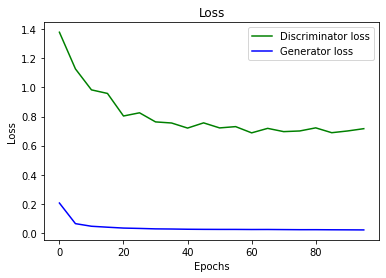

In [ ]:

ep = range(0,100,10)
ep1 = range(0,100,5)

plt.title('Loss')
plt.plot(ep1, MDT, 'g', label='Discriminator loss')
plt.plot(ep1, MGT, 'b', label='Generator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show




<function matplotlib.pyplot.show>

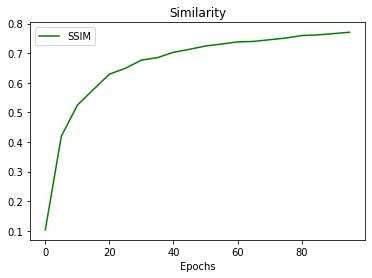

In [ ]:
plt.title('Similarity')
plt.plot(ep1, MSSIM, 'g', label='SSIM')

plt.xlabel('Epochs')
plt.legend()
plt.show

Model evaluation




/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +




[1/100][1/18] (SSIM) = (0.8449)


[1/100][6/18] (SSIM) = (0.8786)


[1/100][11/18] (SSIM) = (0.7769)


[1/100][16/18] (SSIM) = (0.7803)


[1/100][18/18] (Mean_SSIM) = (0.7770)


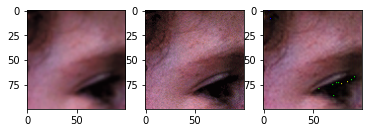



[11/100][1/18] (SSIM) = (0.8824)


[11/100][6/18] (SSIM) = (0.7699)


[11/100][11/18] (SSIM) = (0.7933)


[11/100][16/18] (SSIM) = (0.7159)


[11/100][18/18] (Mean_SSIM) = (0.7770)


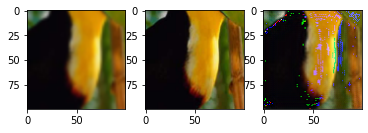

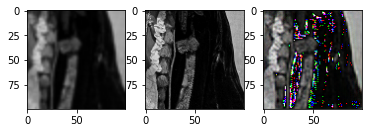



[21/100][1/18] (SSIM) = (0.7740)


[21/100][6/18] (SSIM) = (0.8786)


[21/100][11/18] (SSIM) = (0.7803)


[21/100][16/18] (SSIM) = (0.8793)


[21/100][18/18] (Mean_SSIM) = (0.7770)


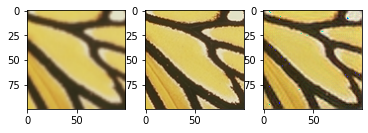

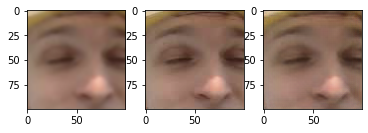



[31/100][1/18] (SSIM) = (0.7769)


[31/100][6/18] (SSIM) = (0.7949)


[31/100][11/18] (SSIM) = (0.8786)


[31/100][16/18] (SSIM) = (0.7699)


[31/100][18/18] (Mean_SSIM) = (0.7770)


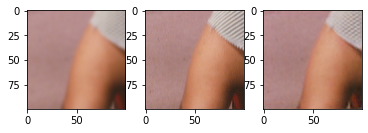

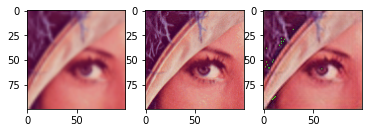



[41/100][1/18] (SSIM) = (0.7933)


[41/100][6/18] (SSIM) = (0.8449)


[41/100][11/18] (SSIM) = (0.5667)


[41/100][16/18] (SSIM) = (0.8793)


[41/100][18/18] (Mean_SSIM) = (0.7770)


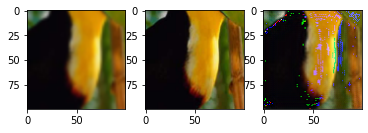

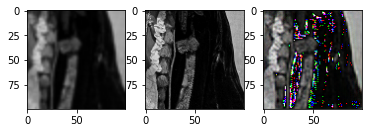



[51/100][1/18] (SSIM) = (0.8786)


[51/100][6/18] (SSIM) = (0.8449)


[51/100][11/18] (SSIM) = (0.7485)


[51/100][16/18] (SSIM) = (0.7159)


[51/100][18/18] (Mean_SSIM) = (0.7770)


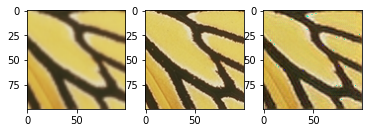



[61/100][1/18] (SSIM) = (0.7699)


[61/100][6/18] (SSIM) = (0.6609)


[61/100][11/18] (SSIM) = (0.7558)


[61/100][16/18] (SSIM) = (0.7933)


[61/100][18/18] (Mean_SSIM) = (0.7770)


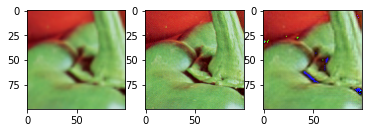

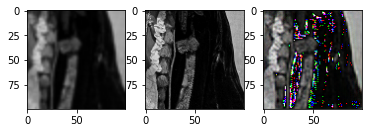



[71/100][1/18] (SSIM) = (0.7933)


[71/100][6/18] (SSIM) = (0.7740)


[71/100][11/18] (SSIM) = (0.7159)


[71/100][16/18] (SSIM) = (0.5667)


[71/100][18/18] (Mean_SSIM) = (0.7770)


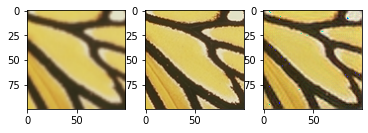

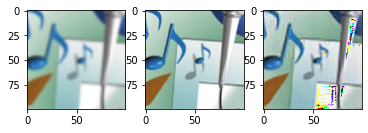



[81/100][1/18] (SSIM) = (0.8824)


[81/100][6/18] (SSIM) = (0.7485)


[81/100][11/18] (SSIM) = (0.7699)


[81/100][16/18] (SSIM) = (0.7933)


[81/100][18/18] (Mean_SSIM) = (0.7770)


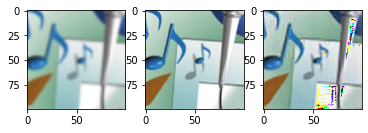

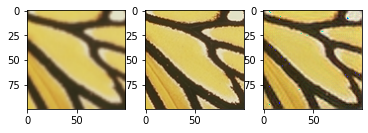



[91/100][1/18] (SSIM) = (0.7949)


[91/100][6/18] (SSIM) = (0.7558)


[91/100][11/18] (SSIM) = (0.8793)


[91/100][16/18] (SSIM) = (0.7485)


[91/100][18/18] (Mean_SSIM) = (0.7770)


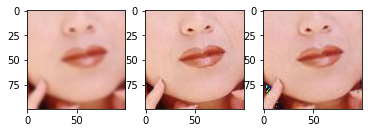

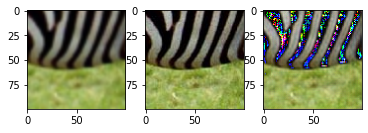



[101/100][1/18] (SSIM) = (0.7933)


[101/100][6/18] (SSIM) = (0.7558)


[101/100][11/18] (SSIM) = (0.8793)


[101/100][16/18] (SSIM) = (0.6609)


[101/100][18/18] (Mean_SSIM) = (0.7770)


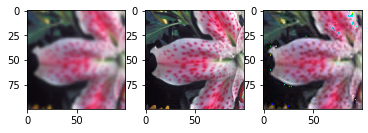



[111/100][1/18] (SSIM) = (0.8449)


[111/100][6/18] (SSIM) = (0.7558)


[111/100][11/18] (SSIM) = (0.7159)


[111/100][16/18] (SSIM) = (0.7485)


[111/100][18/18] (Mean_SSIM) = (0.7770)


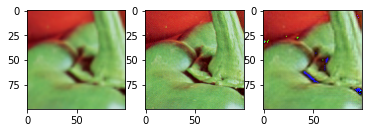

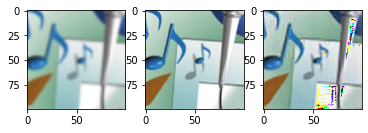



[121/100][1/18] (SSIM) = (0.7558)


[121/100][6/18] (SSIM) = (0.9030)


[121/100][11/18] (SSIM) = (0.8793)


[121/100][16/18] (SSIM) = (0.8824)


[121/100][18/18] (Mean_SSIM) = (0.7770)


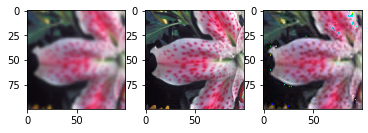

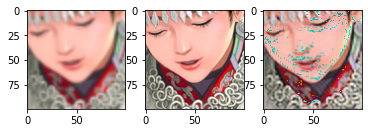



[131/100][1/18] (SSIM) = (0.7949)


[131/100][6/18] (SSIM) = (0.6969)


[131/100][11/18] (SSIM) = (0.7159)


[131/100][16/18] (SSIM) = (0.6609)


[131/100][18/18] (Mean_SSIM) = (0.7770)


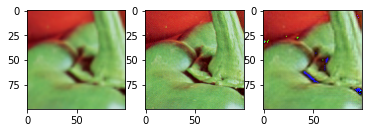

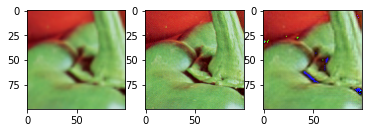



[141/100][1/18] (SSIM) = (0.7769)


[141/100][6/18] (SSIM) = (0.8786)


[141/100][11/18] (SSIM) = (0.8824)


[141/100][16/18] (SSIM) = (0.6609)


[141/100][18/18] (Mean_SSIM) = (0.7770)


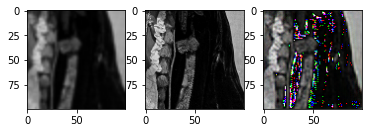

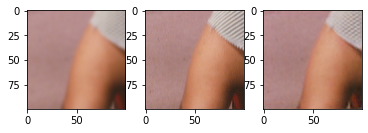



[151/100][1/18] (SSIM) = (0.7558)


[151/100][6/18] (SSIM) = (0.7628)


[151/100][11/18] (SSIM) = (0.8824)


[151/100][16/18] (SSIM) = (0.7803)


[151/100][18/18] (Mean_SSIM) = (0.7770)


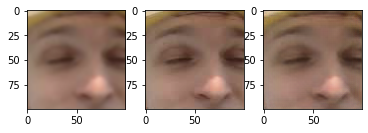



[161/100][1/18] (SSIM) = (0.8793)


[161/100][6/18] (SSIM) = (0.7933)


[161/100][11/18] (SSIM) = (0.7949)


[161/100][16/18] (SSIM) = (0.6969)


[161/100][18/18] (Mean_SSIM) = (0.7770)


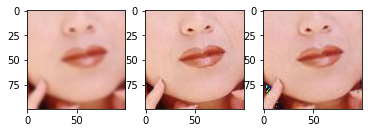

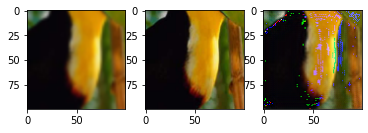



[171/100][1/18] (SSIM) = (0.8449)


[171/100][6/18] (SSIM) = (0.7628)


[171/100][11/18] (SSIM) = (0.7485)


[171/100][16/18] (SSIM) = (0.6609)


[171/100][18/18] (Mean_SSIM) = (0.7770)


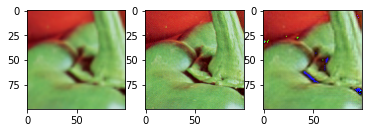

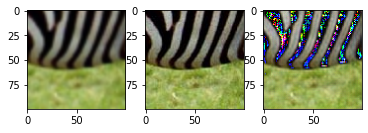



[181/100][1/18] (SSIM) = (0.7803)


[181/100][6/18] (SSIM) = (0.7699)


[181/100][11/18] (SSIM) = (0.7949)


[181/100][16/18] (SSIM) = (0.7628)


[181/100][18/18] (Mean_SSIM) = (0.7770)


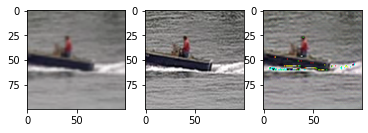

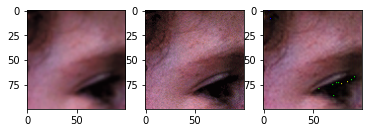



[191/100][1/18] (SSIM) = (0.8824)


[191/100][6/18] (SSIM) = (0.8793)


[191/100][11/18] (SSIM) = (0.7485)


[191/100][16/18] (SSIM) = (0.8786)


[191/100][18/18] (Mean_SSIM) = (0.7770)


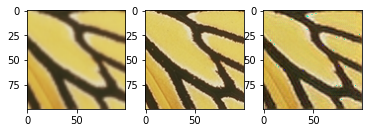

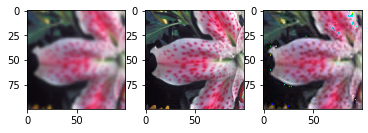

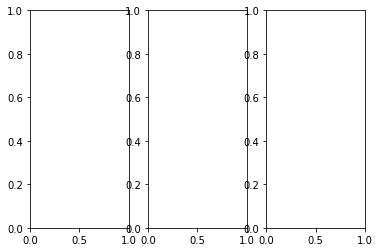

In [ ]:
"""
Evaluating the model

"""

# load the trained model
eval_generator = Generator(16, upSampling)
eval_generator.load_state_dict(torch.load('%s/generator_final.pth' % out))
eval_generator.eval()

dataset = 'test'
dataroot = '/content/data/test'
workers = 1
batchSize = 1
imageSize = 50
upSampling = 2
cuda = True


if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device! You should probably set the variable 'cuda=True'")

# transform the data   
transform = transforms.Compose([transforms.CenterCrop(imageSize*upSampling),
                                transforms.ToTensor()])

normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

scale = transforms.Compose([transforms.ToPILImage(),
                            transforms.Scale(imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

# load test data
if dataset == 'test':
    dataset = datasets.ImageFolder(root=dataroot, transform=transform)
assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=int(workers))

# set the visualizer
visualizer = Visualizer(image_size=imageSize*upSampling)

print("Model evaluation\n\n")

# use GPU if available
if cuda:
    eval_generator.cuda()

low_res = torch.FloatTensor(batchSize, 3, imageSize, imageSize)  

for epoch in range(200):
    
    mean_ssim1 = 0.0
    mean_vifp1 = 0.0
    mean_psnr = 0.0
    
    for i, data in enumerate(dataloader):
        
        # get data
        high_res_real, _ = data
        
        # downsample images to low resolution
        for j in range(batchSize):
            low_res[j] = scale(high_res_real[j])
            high_res_real[j] = normalize(high_res_real[j])
            
        # Generate real and fake inputs
        if cuda:
            high_res_real = Variable(high_res_real.cuda())
            high_res_fake = eval_generator(Variable(low_res).cuda())
        
        else:
            high_res_real = Variable(high_res_real)
            high_res_fake = eval_generator(Variable(low_res))
            
        ssim_val = ssim(high_res_real, high_res_fake)
        mean_ssim1 += ssim_val
        
        #vifp = vifp_measure(high_res_real, high_res_fake)
        #mean_vifp1 += vifp

         
        
        if i%5 == 0 and epoch%10 == 0:
            print('\n')
            print('\r[%d/%d][%d/%d] (SSIM) = (%.4f)' % (epoch + 1, nEpochs, i+1, len(dataloader), ssim_val))
                   
        visualizer.show(low_res, high_res_real.cpu().data, high_res_fake.cpu().data)
        
    if epoch%10==0:
        print('\n')
        print('\r[%d/%d][%d/%d] (Mean_SSIM) = (%.4f)' % (epoch + 1, nEpochs, i+1, len(dataloader), mean_ssim1/len(dataloader)))
    
    